In [1]:
%matplotlib inline
import matplotlib as mpl;
import matplotlib.pyplot as plt;
import pandas as pd;
from datetime import datetime;
import matplotlib.dates as mdates
import numpy as np

In [2]:
import numpy as np;
import gzip;
from io import StringIO;

def parse_header_of_csv(csv_str):
    # Isolate the headline columns:
    headline = csv_str[:csv_str.index('\n')];
    columns = headline.split(',');

    # The first column should be timestamp:
    assert columns[0] == 'timestamp';
    # The last column should be label_source:
    assert columns[-1] == 'label_source';
    
    # Search for the column of the first label:
    for (ci,col) in enumerate(columns):
        if col.startswith('label:'):
            first_label_ind = ci;
            break;
        pass;

    # Feature columns come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind];
    # Then come the labels, till the one-before-last column:
    label_names = columns[first_label_ind:-1];
    for (li,label) in enumerate(label_names):
        # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
        assert label.startswith('label:');
        label_names[li] = label.replace('label:','');
        pass;
    
    return (feature_names,label_names);

def parse_body_of_csv(csv_str,n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO(csv_str),delimiter=',',skiprows=1);
    
    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:,0].astype(int);
    
    # Read the sensor features:
    X = full_table[:,1:(n_features+1)];
    
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = full_table[:,(n_features+1):-1]; # This should have values of either 0., 1. or NaN
    M = np.isnan(trinary_labels_mat); # M is the missing label matrix
    Y = np.where(M,0,trinary_labels_mat) > 0.; # Y is the label matrix
    
    return (X,Y,M,timestamps);

'''
Read the data (precomputed sensor-features and labels) for a user.
This function assumes the user's data file is present.
'''
def read_user_data(uuid):
    user_data_file = '%s.features_labels.csv.gz' % uuid;

    # Read the entire csv file of the user:
    with gzip.open(user_data_file,'rt') as fid:
        csv_str = fid.read();
        pass;

    (feature_names,label_names) = parse_header_of_csv(csv_str);
    n_features = len(feature_names);
    (X,Y,M,timestamps) = parse_body_of_csv(csv_str,n_features);

    return (X,Y,M,timestamps,feature_names,label_names);

In [3]:
def get_sensor_names_from_features(feature_names):
    feat_sensor_names = np.array([None for feat in feature_names]);
    for (fi,feat) in enumerate(feature_names):
        if feat.startswith('raw_acc'):
            feat_sensor_names[fi] = 'Acc';
            pass;
        elif feat.startswith('proc_gyro'):
            feat_sensor_names[fi] = 'Gyro';
            pass;
        elif feat.startswith('raw_magnet'):
            feat_sensor_names[fi] = 'Magnet';
            pass;
        elif feat.startswith('watch_acceleration'):
            feat_sensor_names[fi] = 'WAcc';
            pass;
        elif feat.startswith('watch_heading'):
            feat_sensor_names[fi] = 'Compass';
            pass;
        elif feat.startswith('location'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('location_quick_features'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('audio_naive'):
            feat_sensor_names[fi] = 'Aud';
            pass;
        elif feat.startswith('audio_properties'):
            feat_sensor_names[fi] = 'AP';
            pass;
        elif feat.startswith('discrete'):
            feat_sensor_names[fi] = 'PS';
            pass;
        elif feat.startswith('lf_measurements'):
            feat_sensor_names[fi] = 'LF';
            pass;
        else:
            raise ValueError("!!! Unsupported feature name: %s" % feat);

        pass;

    return feat_sensor_names;    

In [4]:
def get_actual_date_labels(tick_seconds):
    import datetime;
    import pytz;
    
    time_zone = pytz.timezone('US/Pacific'); # Assuming the data comes from PST time zone
    weekday_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'];
    datetime_labels = [];
    for timestamp in tick_seconds:
        tick_datetime = datetime.datetime.fromtimestamp(timestamp,tz=time_zone);
        weekday_str = weekday_names[tick_datetime.weekday()];
        time_of_day = tick_datetime.strftime('%I:%M%p');
        datetime_labels.append('%s\n%s' % (weekday_str,time_of_day));
        pass;
    
    return datetime_labels;

In [5]:
def figure__feature_track_and_hist(X,feature_names,timestamps,feature_inds,timepace):
    seconds_in_day = (60*60*24);
    days_since_participation = (timestamps - timestamps[0]) / float(seconds_in_day);
    
    
    for ind in feature_inds:
        feature = feature_names[ind];
        feat_values = X[:,ind]; #
        
        fig = plt.figure(figsize=(20,8),facecolor='white');
        
        ax1 = plt.subplot(3,1,1);
        ax1.plot(timestamps,feat_values,'-',markersize=3,linewidth=1);
        tick_seconds = range(timestamps[0],timestamps[-1],timepace);
        tick_labels = get_actual_date_labels(tick_seconds);
        ax1.set_xticks(tick_seconds);
        ax1.set_xticklabels(tick_labels,fontsize=14);
        
        plt.xlabel('days of participation');
        plt.ylabel('feature value');
        plt.title('%d) %s\nfunction of time' % (ind,feature));   
        
        pass;
    
    return;

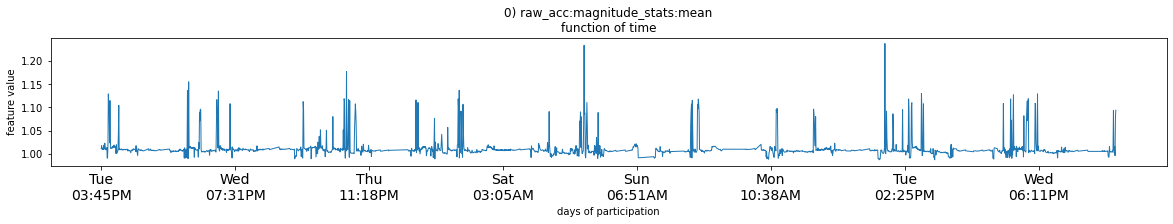

In [6]:
uuid = '1155FF54-63D3-4AB2-9863-8385D0BD0A13';
(X,Y,M,timestamps,feature_names,label_names) = read_user_data(uuid);
feature_inds = [0];
figure__feature_track_and_hist(X,feature_names,timestamps,feature_inds,100000);

In [7]:
def figure__feature_track_and_hist2(X,feature_names,timestamps,feature_inds):
    import pytz;
    time_zone = pytz.timezone('US/Pacific');
    seconds_in_day = (60*60*24);
    days_since_participation = (timestamps - timestamps[0]) / float(seconds_in_day);
    
    
    for ind in feature_inds:
        feature = feature_names[ind];
        feat_values = X[:,ind];
        
        #Segmentando a timeseries por dias da semana e formatando em horas do dia
        segunda=[str(datetime.fromtimestamp(i,tz=time_zone).time()) for i in timestamps[1667:2004]];
        segundaX=feat_values[1667:2004];
        terca = [str(datetime.fromtimestamp(i,tz=time_zone).time()) for i in timestamps[2005:2318]];
        tercaX = feat_values[2005:2318];
        quarta=[str(datetime.fromtimestamp(i,tz=time_zone).time()) for i in timestamps[172:499]];
        quartaX=feat_values[172:499];
        quinta=[str(datetime.fromtimestamp(i,tz=time_zone).time()) for i in timestamps[500:774]];
        quintaX=feat_values[500:774];
        sexta=[str(datetime.fromtimestamp(i,tz=time_zone).time()) for i in timestamps[775:1028]];
        sextaX=feat_values[775:1028];
        sabado=[str(datetime.fromtimestamp(i,tz=time_zone).time()) for i in timestamps[1489:1666]];
        sabadoX=feat_values[1489:1666];
        domingo=[str(datetime.fromtimestamp(i,tz=time_zone).time()) for i in timestamps[1667:2004]];
        domingoX=feat_values[1667:2004];
        
        fig = plt.figure(figsize=(20,15),facecolor='white');
        locator = mdates.HourLocator(interval=1000);
        fig.tight_layout(pad=5.0)
        
        ax1 = plt.subplot(7,1,1);        
        ax1.xaxis.set_major_locator(locator);
        ax1.plot(segunda,segundaX,'-',markersize=3,linewidth=1);        
        
        ax1 = plt.subplot(7,1,2);
        ax1.xaxis.set_major_locator(locator)
        ax1.plot(terca,tercaX,'-',markersize=3,linewidth=1);        
        
        ax1 = plt.subplot(7,1,3);
        ax1.xaxis.set_major_locator(locator)
        ax1.plot(quarta,quartaX,'-',markersize=3,linewidth=1);
        
        ax1 = plt.subplot(7,1,4);
        ax1.xaxis.set_major_locator(locator)
        ax1.plot(quinta,quintaX,'-',markersize=3,linewidth=1);
        
        ax1 = plt.subplot(7,1,5);
        ax1.xaxis.set_major_locator(locator)
        ax1.plot(sexta,sextaX,'-',markersize=3,linewidth=1);
        
        ax1 = plt.subplot(7,1,6);
        ax1.xaxis.set_major_locator(locator)
        ax1.plot(sabado,sabadoX,'-',markersize=3,linewidth=1);        
        
        ax1 = plt.subplot(7,1,7);
        ax1.xaxis.set_major_locator(locator)
        ax1.plot(domingo,domingoX,'-',markersize=3,linewidth=1);
        pass;
    return;

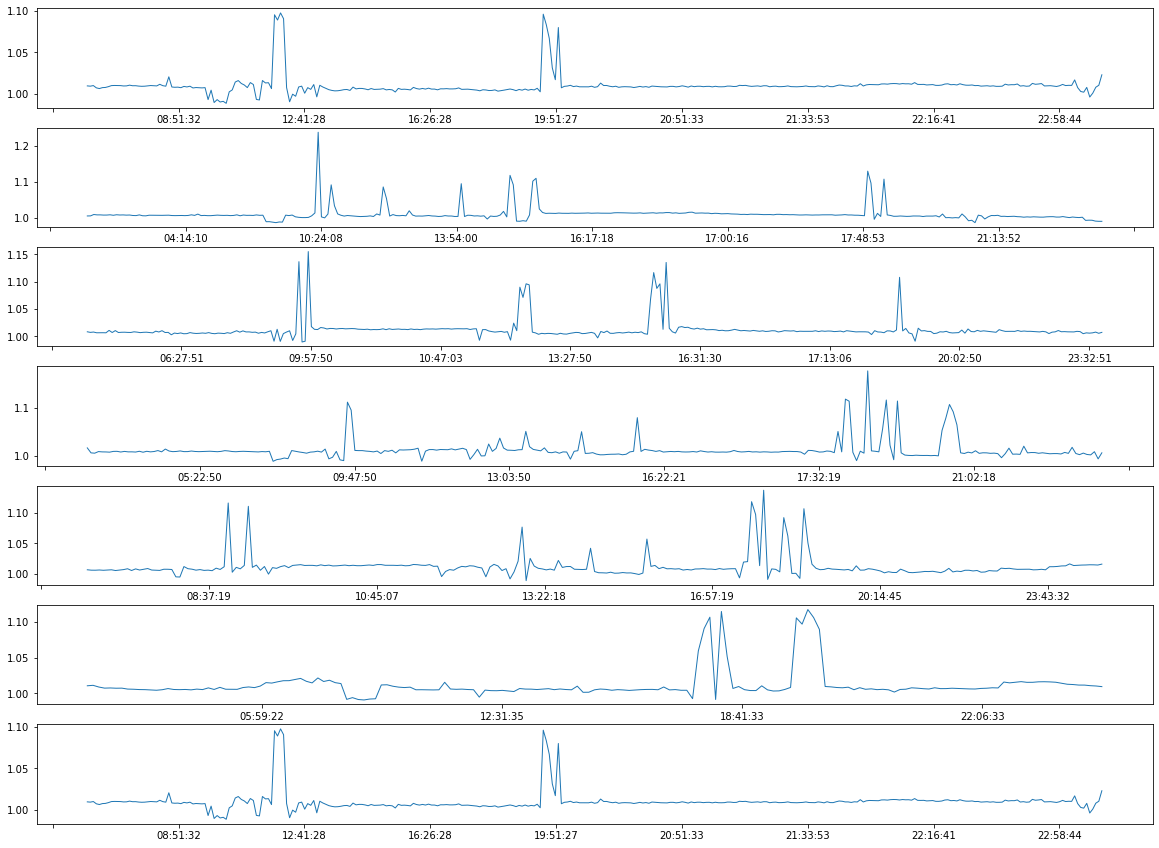

In [8]:
figure__feature_track_and_hist2(X,feature_names,timestamps,feature_inds);

In [31]:
import pytz;
#Agrupando em um dataframe
time_zone = pytz.timezone('US/Pacific');
data = pd.DataFrame()
data['Datetime'] = pd.DatetimeIndex([datetime.fromtimestamp(i,tz=time_zone) for i in timestamps])
data = pd.concat([data, pd.DataFrame(X,columns=feature_names)], axis=1)
data.index = data['Datetime']
data = data.groupby(pd.Grouper(key='Datetime', axis=0, freq='10min')).mean()
data = data.first('7D')
data['Dayweek'] = data.index.dayofweek

#segmentando por dia da semana
segunda = data[data['Dayweek']==0]
segunda.index = segunda.index.time
terca = data[data['Dayweek']==1]
terca.index = terca.index.time
quarta = data[data['Dayweek']==2]
quarta.index = quarta.index.time
quinta = data[data['Dayweek']==3]
quinta.index = quinta.index.time
sexta = data[data['Dayweek']==4]
sexta.index = sexta.index.time
sabado = data[data['Dayweek']==5]
sabado.index = sabado.index.time
domingo = data[data['Dayweek']==6]
domingo.index = domingo.index.time

In [11]:
feat_sensor_names = get_sensor_names_from_features(feature_names);

for (fi,feature) in enumerate(feature_names):
    print("%3d) %s %s" % (fi,feat_sensor_names[fi].ljust(10),feature));
    pass;

  0) Acc        raw_acc:magnitude_stats:mean
  1) Acc        raw_acc:magnitude_stats:std
  2) Acc        raw_acc:magnitude_stats:moment3
  3) Acc        raw_acc:magnitude_stats:moment4
  4) Acc        raw_acc:magnitude_stats:percentile25
  5) Acc        raw_acc:magnitude_stats:percentile50
  6) Acc        raw_acc:magnitude_stats:percentile75
  7) Acc        raw_acc:magnitude_stats:value_entropy
  8) Acc        raw_acc:magnitude_stats:time_entropy
  9) Acc        raw_acc:magnitude_spectrum:log_energy_band0
 10) Acc        raw_acc:magnitude_spectrum:log_energy_band1
 11) Acc        raw_acc:magnitude_spectrum:log_energy_band2
 12) Acc        raw_acc:magnitude_spectrum:log_energy_band3
 13) Acc        raw_acc:magnitude_spectrum:log_energy_band4
 14) Acc        raw_acc:magnitude_spectrum:spectral_entropy
 15) Acc        raw_acc:magnitude_autocorrelation:period
 16) Acc        raw_acc:magnitude_autocorrelation:normalized_ac
 17) Acc        raw_acc:3d:mean_x
 18) Acc        raw_acc:3d:mean_y


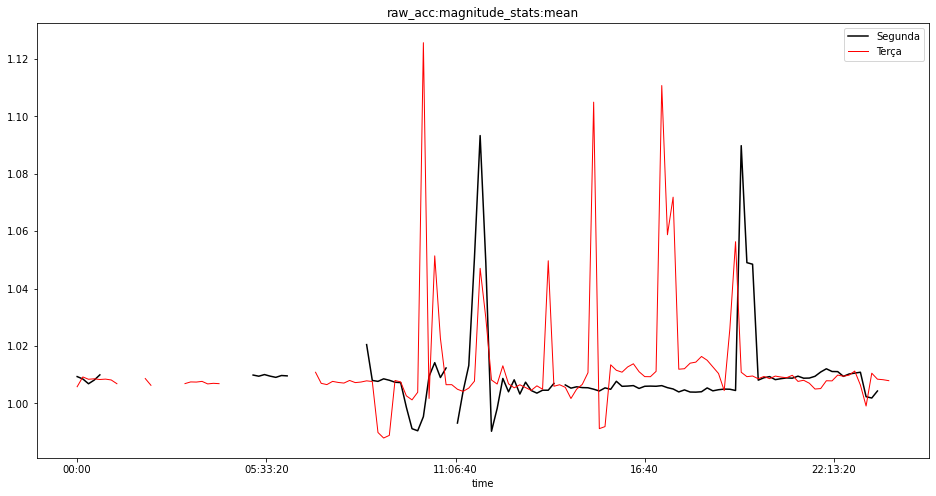

In [32]:
ind = 0;
fig, axs = plt.subplots(figsize=(16, 8));
plt.title(segunda.columns[ind]);
segunda.iloc[:,ind].plot(label='Segunda',color='black',legend=True);
terca.iloc[:,ind].plot(label='Terça',color='red',legend=True,linewidth=1);
#quarta.iloc[:,ind].plot(label='Quarta',legend=True,color='orange',linewidth=1);
#quinta.iloc[:,ind].plot(label='Quinta',legend=True,color='c');
#sexta.iloc[:,ind].plot(label='Sexta',legend=True,color='green');
#sabado.iloc[:,ind].plot(label='Sabado',legend=True,color='m');
#domingo.iloc[:,ind].plot(label='Domingo',legend=True,color='b');

In [ ]:
fig.

In [ ]:
segunda.index = segunda.index.time

In [ ]:
axs.title